In [1]:
# NB need to use environment with python3.9 or above for ccf_streamlines to run
import nrrd
import numpy as np
import matplotlib.pyplot as plt
import ccf_streamlines.projection as ccfproj
import pathlib
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import copy
import seaborn as sb
import nrrd
#from preprocessing_sequencing import preprocess_sequences as ps
from bg_atlasapi import BrainGlobeAtlas
#from final_processing import final_processing_functions as fpf
import additional_functions as af
import ast
import yaml
from scipy.ndimage import zoom
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
%matplotlib inline


In [2]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
roi_dict = {}
sample_vol_and_regions = {}
parameters_dict = {}
barcodes_dict = {}
all_bcs_with_source = {}
scaling_factor = 25 / 10  # since we need in 10um resolution, we need to convert 25um resolution registered cubelets to 10um
zoom_factors = (scaling_factor, scaling_factor, scaling_factor)
for mouse in mice:
    lcm_directory = pathlib.Path(
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/LCM"
    )
    # load datasets
    barcodes_across_sample = pd.read_pickle(
        f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/A1_barcodes_thresholded_with_source.pkl"
    )
    all_bcs_with_source[mouse]= barcodes_across_sample
    barcodes_dict[mouse] = barcodes_across_sample[barcodes_across_sample.sum(axis=1)>0]
    ROI_3D = np.load(lcm_directory / "ROI_3D_25.npy")
    not_in = [x for x in np.unique(ROI_3D) if x not in barcodes_across_sample.columns and x != 0]
    ROI_3D[np.isin(ROI_3D, not_in)] = 0
    sample_vol_and_regions[mouse] =pd.read_pickle(lcm_directory/'sample_vol_and_regions.pkl')
    parameters_dict[mouse] = af.load_parameters(directory=f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing/")
    mask = np.isin(ROI_3D, parameters_dict[mouse]['cortical_samples'])
    ROI_3D[~mask] = 0
    roi_dict[mouse] = zoom(ROI_3D, zoom=zoom_factors, order=0)
    # A1 = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    # barcodes_across_sample = barcodes_across_sample[barcodes_across_sample.idxmax(axis=1).isin(A1)]
# this is the path to where the ccf streamlines downloads is (so don't change when looking a different mice)
convert_to_flat_path = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration"
)
annotation_data = nrrd.read("/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/flatmap_butterfly.nrrd")
labels_df =  pd.read_csv(
            "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/LCM_registration/labelDescription_ITKSNAPColor.txt",
            header=None,
            sep="\s+",
            index_col=0
        )
labels_df.columns = ["r", "g", "b", "x0", "x1", "x2", "acronym"]
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file=convert_to_flat_path / "flatmap_butterfly.nrrd",
    labels_file=convert_to_flat_path / "labelDescription_ITKSNAPColor.txt",
)

# We get the left hemisphere region boundaries with the default arguments
bf_left_boundaries = bf_boundary_finder.region_boundaries()

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere="right_for_both",
    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere="flatmap_butterfly",
)
proj_top = ccfproj.Isocortex2dProjector(
    # Specify our view lookup file
    convert_to_flat_path / "flatmap_butterfly.h5",
    # Specify our streamline file
    convert_to_flat_path / "surface_paths_10_v3.h5",
    # Specify that we want to project both hemispheres
    hemisphere="both",
    # The top view contains space for the right hemisphere, but is empty.
    # Therefore, we tell the projector to put both hemispheres side-by-side
    view_space_for_other_hemisphere="flatmap_butterfly",
)

ref_anno = nrrd.read('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/LCM_registration/reference/annotation_25.nrrd')
allen_anno = np.array(ref_anno)
annotation = allen_anno[0]

loading path information


100%|██████████| 1016/1016 [00:06<00:00, 153.96it/s]
/tmp/ipykernel_2608690/4231451716.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allen_anno = np.array(ref_anno)


/tmp/ipykernel_2608690/753174500.py:31: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_2608690/753174500.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


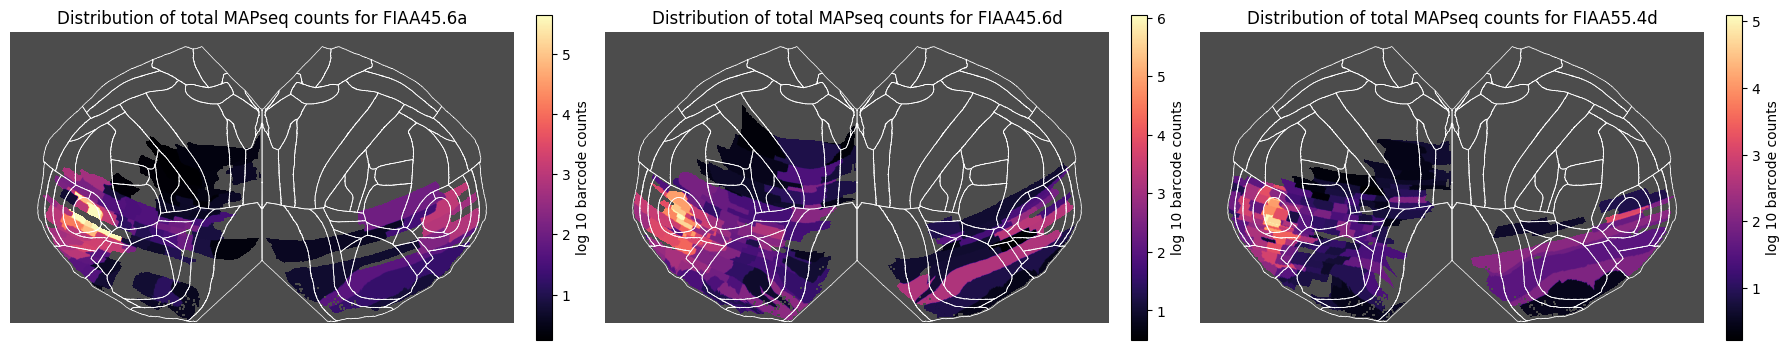

In [3]:
# SSp_regions = []
# # SSp_all_coords ={}
# for key in bf_left_boundaries.keys():
#     if 'SSp' in key:
#         SSp_regions.append(str(key))
#         # coords = bf_left_boundaries[key]
#         # SSp_all_coords[key] = coords
# new_left_bound_dict = {key: value for key, value in bf_left_boundaries.items() if key not in SSp_regions}    
# new_right_bound_dict = {key: value for key, value in bf_right_boundaries.items() if key not in SSp_regions}    
# use if you don't want to show detail of SSp
all_mice_flat = {}
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
for ax, mouse in zip(axes, mice):
    # Access barcodes across sample for the current mouse
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    
    # Fill the barcode matrix
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    
    # Calculate total counts and set zero values to -1
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
    new_mat = np.flip(new_mat, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
    all_mice_flat[mouse] = new_mat
    # Set up the color map
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # Set NaN values as grey

    # Plot the heatmap on the current axis
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    
    # Add color bar to each subplot
    fig.colorbar(im, ax=ax, label="log 10 barcode counts", fraction=0.03, pad=0.04)

    # Plot the boundaries for each side
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    # Set the title for each subplot
    ax.set_title(f"Distribution of total MAPseq counts for {mouse}")

# Adjust layout to make space between subplots
plt.tight_layout()
plt.show()
# Save the figure with three subplots
#plt.savefig("/camp/lab/znamenskiyp/home/shared/code/MAPseq_processing/figs/MAPseq_bulk_counts.png", bbox_inches='tight', dpi=300)

# Clear the current figure to avoid overwriting or displaying
#plt.clf()

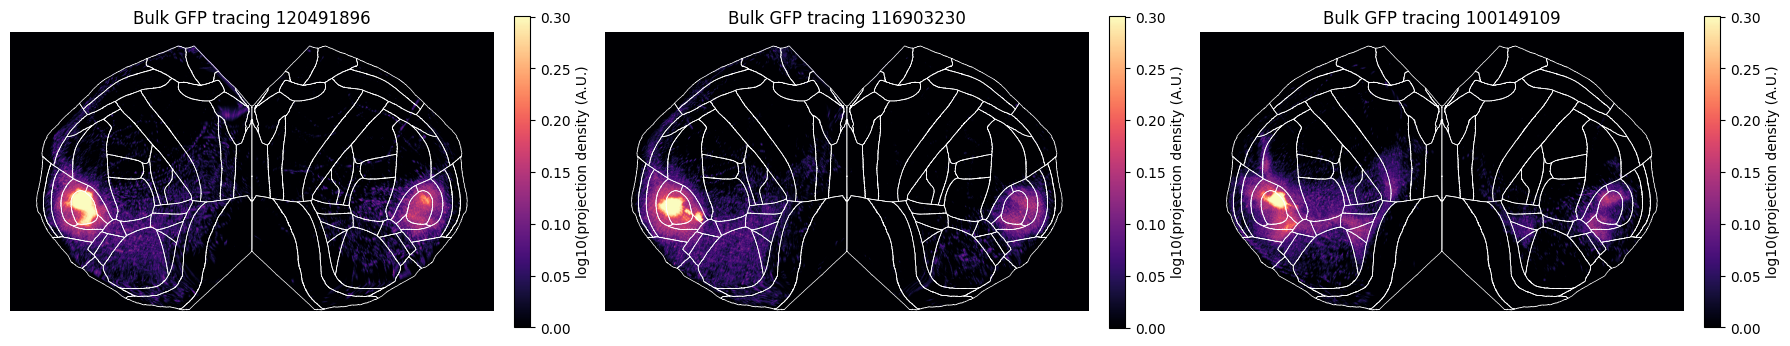

In [4]:
mcc = MouseConnectivityCache(resolution=10)
rsp = mcc.get_reference_space()
cortex_mask = rsp.make_structure_mask([688], direct_only=False) #688 is id for whole  cortex
download_allen = pathlib.Path(
    "/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/Allen_Connectivity"
)
# allen anterograde tracing datasets with more than 75% injection site AUDp

experiment_id_a = 120491896  # AUDp
experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
experiment_id_c = 100149109  # AUDp and AUDd

expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
ids = [120491896, 116903230, 100149109]
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
expts = [expt_a, expt_b, expt_c]
i =0
for ax, expt in zip(axes, expts):
    expt_cortex= expt *cortex_mask
    projection_max = proj_top.project_volume(expt_cortex)
    to_look = np.log10(projection_max+1).T
    to_look = np.flip(to_look, axis=1)
    #plt.imshow(to_look, cmap='magma')
    im = ax.imshow(to_look, cmap='magma')
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(projection density (A.U.)", fraction=0.03, pad=0.04)
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    ax.set_title(f"Bulk GFP tracing {[ids][0][i]}")
    i += 1

plt.tight_layout()
plt.show()

/tmp/ipykernel_2608690/2993548695.py:20: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_2608690/2993548695.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


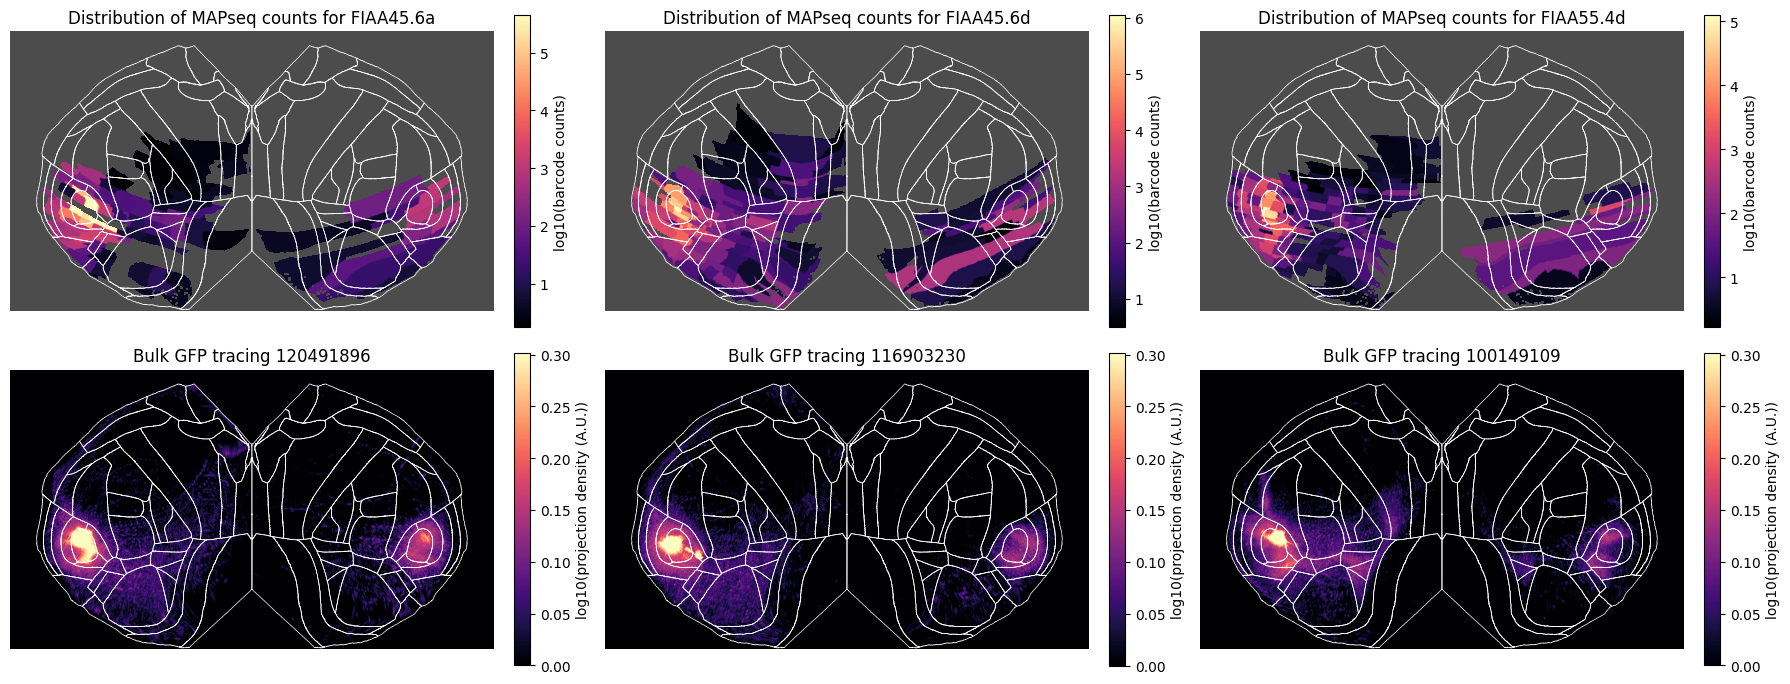

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # Two rows, three columns
all_mice_flat = {}

# First row: MAPseq counts for each mouse
for i, (ax, mouse) in enumerate(zip(axes[0], mice)):
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse]
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()

    # Compute total counts and log-transform
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
    new_mat = np.flip(new_mat, axis=1)  # Adjust orientation
    all_mice_flat[mouse] = new_mat

    # Configure the colormap
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # NaN values as grey

    # Plot the heatmap
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(barcode counts)", fraction=0.03, pad=0.04)

    # Plot boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    ax.set_title(f"Distribution of MAPseq counts for {mouse}")

mcc = MouseConnectivityCache(resolution=10)
rsp = mcc.get_reference_space()
cortex_mask = rsp.make_structure_mask([688], direct_only=False)  # 688 = cortex ID

experiment_id_a = 120491896  # AUDp
experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
experiment_id_c = 100149109  # AUDp and AUDd
expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
expts = [expt_a, expt_b, expt_c]
ids = [experiment_id_a, experiment_id_b, experiment_id_c]

for i, (ax, expt) in enumerate(zip(axes[1], expts)):
    expt_cortex = expt * cortex_mask
    projection_max = proj_top.project_volume(expt_cortex)
    to_look = np.log10(projection_max + 1).T
    to_look = np.flip(to_look, axis=1)  # Adjust orientation
    im = ax.imshow(to_look, cmap='magma')
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(projection density (A.U.))", fraction=0.03, pad=0.04)
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    ax.set_title(f"Bulk GFP tracing {ids[i]}")

plt.tight_layout()
plt.show()

/tmp/ipykernel_2608690/2955234603.py:28: RuntimeWarning: divide by zero encountered in log10
  new_mat = np.log10(1 + total_counts[rebuilding_all_flatmap.astype(int)]).T
/tmp/ipykernel_2608690/2955234603.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


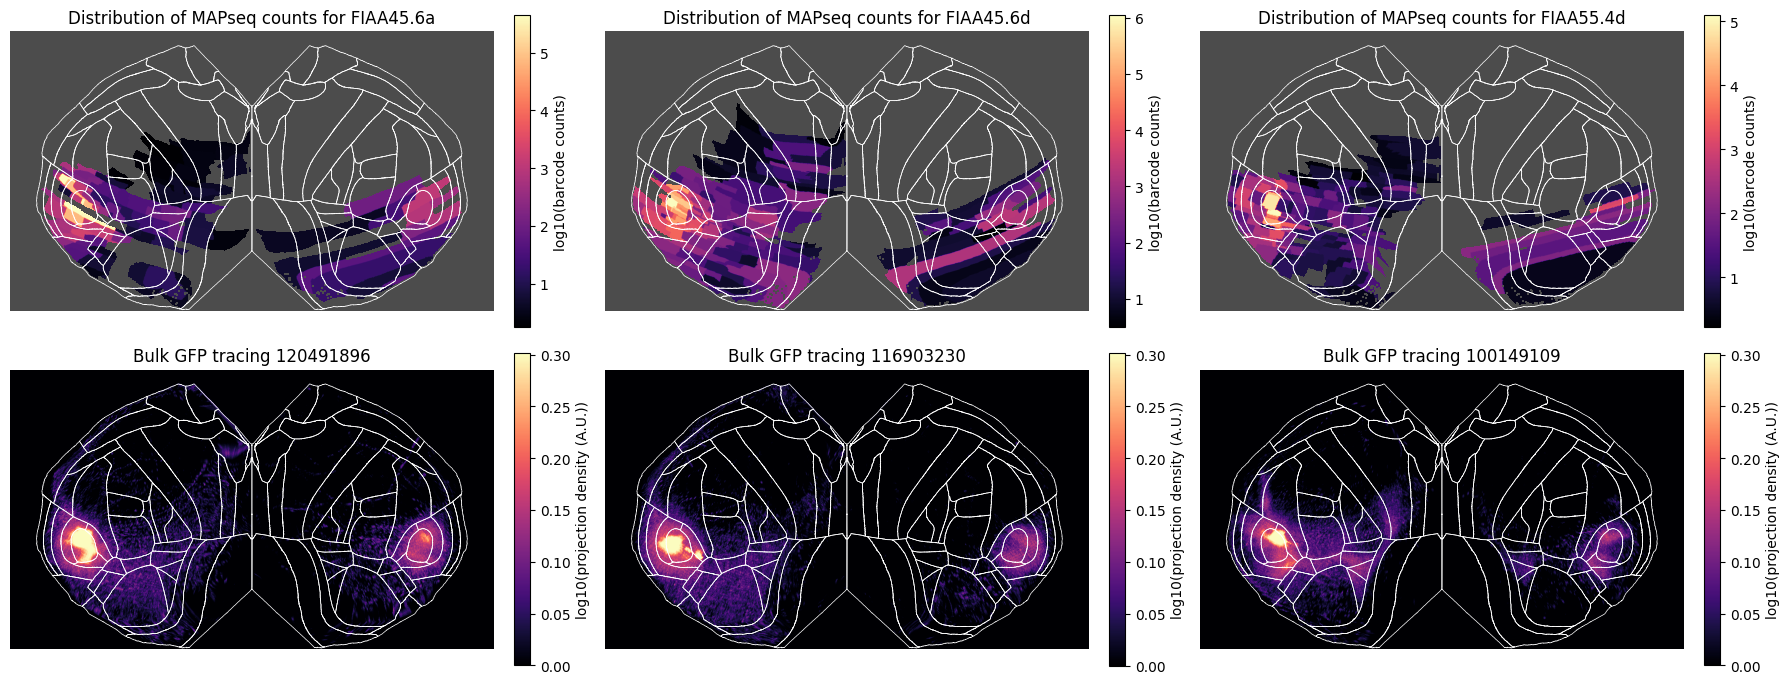

In [8]:
#get rid of overlapping rois due to flatmap artifacts
fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # Two rows, three columns
all_mice_flat = {}

# First row: MAPseq counts for each mouse
for i, (ax, mouse) in enumerate(zip(axes[0], mice)):
    #ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    roi_to_look = roi_dict[mouse]
    all_flatmap = proj_top.project_volume(roi_to_look)
    rebuilding_all_flatmap = np.zeros_like(all_flatmap)
    barcodes_across_sample = barcodes_dict[mouse]
    for roi in barcodes_across_sample.columns:
        binary_roi_array = np.where(roi_to_look == roi, roi, 0)
        flat_projection = proj_top.project_volume(binary_roi_array)
        rebuilding_all_flatmap[rebuilding_all_flatmap == 0] = flat_projection[rebuilding_all_flatmap == 0]
    barcodes_across_sample = barcodes_dict[mouse]
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()

    # Compute total counts and log-transform
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    new_mat = np.log10(1 + total_counts[rebuilding_all_flatmap.astype(int)]).T
    new_mat = np.flip(new_mat, axis=1)  # Adjust orientation
    all_mice_flat[mouse] = new_mat

    # Configure the colormap
    cmap = plt.cm.get_cmap("magma").copy()
    cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # NaN values as grey

    # Plot the heatmap
    im = ax.imshow(new_mat, cmap=cmap)
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(barcode counts)", fraction=0.03, pad=0.04)

    # Plot boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    ax.set_title(f"Distribution of MAPseq counts for {mouse}")

# Second row: GFP tracing
# Set up MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=10)
rsp = mcc.get_reference_space()
cortex_mask = rsp.make_structure_mask([688], direct_only=False)  # 688 = cortex ID

experiment_id_a = 120491896  # AUDp
experiment_id_b = 116903230  # AUDp, AUDpo, AUDd, AUDv
experiment_id_c = 100149109  # AUDp and AUDd
expt_a, pd_a_info = mcc.get_projection_density(experiment_id_a)
expt_b, pd_b_info = mcc.get_projection_density(experiment_id_b)
expt_c, pd_c_info = mcc.get_projection_density(experiment_id_c)
expts = [expt_a, expt_b, expt_c]
ids = [experiment_id_a, experiment_id_b, experiment_id_c]

# Second row: GFP projections for each experiment
for i, (ax, expt) in enumerate(zip(axes[1], expts)):
    expt_cortex = expt * cortex_mask
    projection_max = proj_top.project_volume(expt_cortex)
    to_look = np.log10(projection_max + 1).T
    to_look = np.flip(to_look, axis=1)  # Adjust orientation

    # Plot projection density
    im = ax.imshow(to_look, cmap='magma')
    ax.axis("off")
    fig.colorbar(im, ax=ax, label="log10(projection density (A.U.))", fraction=0.03, pad=0.04)

    # Plot boundaries
    for k, boundary_coords in bf_left_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)
    for k, boundary_coords in bf_right_boundaries.items():
        ax.plot(*boundary_coords.T, c="white", lw=0.5)

    ax.set_title(f"Bulk GFP tracing {ids[i]}")

# Adjust layout and display
plt.tight_layout()
plt.show()

/tmp/ipykernel_1212342/786691043.py:17: RuntimeWarning: divide by zero encountered in log10
  raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T
/tmp/ipykernel_1212342/786691043.py:30: RuntimeWarning: Mean of empty slice
  mean_z_normalized = np.nanmean(all_mice_array, axis=0)
/tmp/ipykernel_1212342/786691043.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("magma").copy()


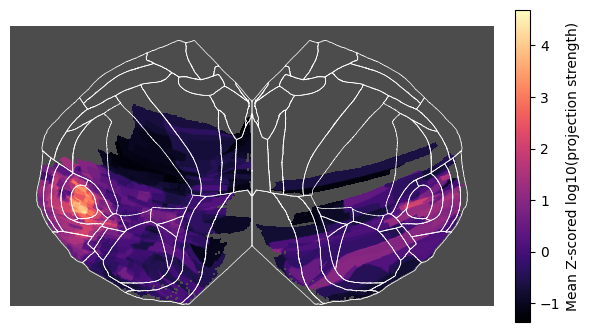

In [ ]:

all_mice_normalized = []

# Iterate through mice and z-normalize data
for mouse in mice:
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

    valid_data = raw_data[raw_data >= 0]  
    mean = np.mean(valid_data)
    std = np.std(valid_data)
    z_normalized = (raw_data - mean) / std
    z_normalized[raw_data < 0] = np.nan 

    
    all_mice_normalized.append(z_normalized)

all_mice_array = np.stack(all_mice_normalized, axis=0)

mean_z_normalized = np.nanmean(all_mice_array, axis=0)
mean_z_normalized = np.flip(mean_z_normalized, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # 

im = ax.imshow(mean_z_normalized, cmap=cmap)
ax.axis("off")

fig.colorbar(im, ax=ax, label="Mean Z-scored log10(projection strength)", fraction=0.03, pad=0.04)

for k, boundary_coords in new_left_bound_dict.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in new_right_bound_dict.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)

#ax.set_title("Mean Z-scored log10(projection strength)")

plt.tight_layout()
plt.show()

In [6]:
#if we want to take the mean projection, for every pixel, if it is not zero (i.e. if there is a cubelet there) plot the mean

mean_array_dict = {}

for key in no_soma_dict.keys():
    # Get the current DataFrame and corresponding 3D array
    normalised_bc = no_soma_dict[mouse].div(no_soma_dict[mouse].sum(axis=1), axis=0)
    roi_3d = roi_dict[key]
    
    # Create an array to accumulate values and a count array to track barcodes mapped to each voxel
    accum_array = np.zeros_like(roi_3d, dtype=np.float64)
    count_array = np.zeros_like(roi_3d, dtype=np.int64)
    
    # Iterate over rows in the DataFrame
    for _, row in normalised_bc.iterrows():
        for col in normalised_bc.columns:
            voxel_value = int(col)  # Convert column name to integer voxel index
            # Find the positions in ROI_3D corresponding to the voxel_value
            voxel_mask = (roi_3d == voxel_value)
            
            # Add only if the voxel exists in ROI_3D
            if np.any(voxel_mask):  # Ensure there are mapped positions
                accum_array[voxel_mask] += row[col]
                count_array[voxel_mask] += 1
    
    # Compute the mean array by dividing accumulated values by counts, avoiding division by zero
    mean_array = np.divide(
        accum_array, 
        count_array, 
        out=np.full_like(accum_array, np.nan, dtype=np.float64),  # Fill with NaN where count is 0
        where=(count_array != 0)
    )
    
    # Store the mean array in the dictionary
    mean_array_dict[key] = mean_array

# Compute the overall mean array across all keys
total_sum = np.zeros_like(next(iter(mean_array_dict.values())))
total_count = np.zeros_like(total_sum, dtype=np.int64)

for key, mean_array in mean_array_dict.items():
    valid_mask = ~np.isnan(mean_array)  # Valid positions (mapped voxels)
    total_sum[valid_mask] += mean_array[valid_mask]
    total_count[valid_mask] += 1

overall_mean = np.divide(
    total_sum,
    total_count,
    out=np.full_like(total_sum, np.nan, dtype=np.float64),
    where=(total_count != 0)
)

print("Overall mean array:")
print(overall_mean)


NameError: name 'no_soma_dict' is not defined

In [ ]:

all_mice_normalized = []

# Iterate through mice and normalise to max projection
for mouse in mice:
    ROI_projection_max = proj_top.project_volume(roi_dict[mouse])
    barcodes_across_sample = barcodes_dict[mouse] 
    barcode_matrix = np.zeros(
        (
            len(barcodes_across_sample),
            int(max(barcodes_across_sample.columns.to_list())) + 1,
        )
    )
    for column in barcodes_across_sample:
        barcode_matrix[:, int(column)] = barcodes_across_sample[column].to_numpy()
    total_counts = np.sum(barcode_matrix, axis=0)
    total_counts[0] = -1
    raw_data = np.log10(1 + total_counts[ROI_projection_max.astype(int)]).T

    valid_data = raw_data[raw_data >= 0]  
    mean = np.mean(valid_data)
    std = np.std(valid_data)
    z_normalized = (raw_data - mean) / std
    z_normalized[raw_data < 0] = np.nan 

    
    all_mice_normalized.append(z_normalized)

all_mice_array = np.stack(all_mice_normalized, axis=0)

mean_z_normalized = np.nanmean(all_mice_array, axis=0)
mean_z_normalized = np.flip(mean_z_normalized, axis=1) # since process of turning into flatmap flips orientation, we make it same as it should be
fig, ax = plt.subplots(figsize=(6, 6))

cmap = plt.cm.get_cmap("magma").copy()
cmap.set_bad(color=[0.3, 0.3, 0.3, 1])  # 

im = ax.imshow(mean_z_normalized, cmap=cmap)
ax.axis("off")

fig.colorbar(im, ax=ax, label="Mean Z-scored log10(projection strength)", fraction=0.03, pad=0.04)

for k, boundary_coords in new_left_bound_dict.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)
for k, boundary_coords in new_right_bound_dict.items():
    ax.plot(*boundary_coords.T, c="white", lw=0.5)

#ax.set_title("Mean Z-scored log10(projection strength)")

plt.tight_layout()
plt.show()

array([nan])